In [62]:
import pandas as pd
import seaborn as sns
import warnings
import numpy as np
from scipy.stats import norm, mannwhitneyu, ttest_ind
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
plt.style.use('ggplot')

In [38]:
warnings.filterwarnings('ignore')

In [45]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

In [3]:
hw_bootstrap = pd.read_csv('hw_bootstrap.csv', sep = ';', index_col=0)

In [4]:
hw_bootstrap

,value,experimentVariant
1,"10,3804953740268",Control
2,"9,54686666784264",Control
3,"11,0882146509904",Control
4,"10,1472740570122",Control
5,"9,78980767524929",Control
...,...,...
996,1000,Treatment
997,1200,Treatment
998,1500,Treatment
999,2000,Treatment


In [16]:
hw_bootstrap.isna().sum()

value                0
experimentVariant    0
dtype: int64

In [17]:
hw_bootstrap.dtypes

value                object
experimentVariant    object
dtype: object

In [19]:
hw_bootstrap['value'] = hw_bootstrap.value.apply(lambda x : float(x.replace(',', '.')))

In [22]:
control= hw_bootstrap.query("experimentVariant == 'Control'")
treatment= hw_bootstrap.query("experimentVariant == 'Treatment'")

In [40]:
print('control mean : {} | treatment mean {}'.format(control.value.mean(), treatment.value.mean()))

control mean : 10.0268665338043 | treatment mean 27.321499056661583


In [42]:
print('control median : {} | treatment median {}'.format(control.value.median(), treatment.value.median()))

control median : 10.0184651909296 | treatment median 10.02584684253515


### Средние сильно различаются, хотя медианы почти равны

### Возможно в данных выбросы

### Построим распределения

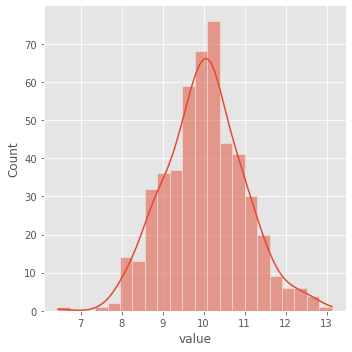

In [67]:
sns.displot(control.value, kde=True);

### Наблюдаем выбросы

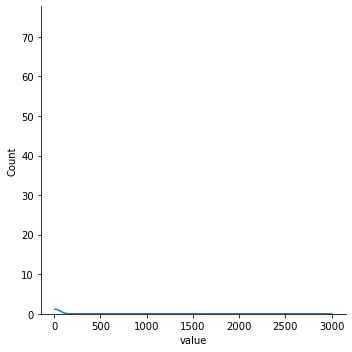

In [32]:
sns.displot(treatment.value, kde=True);

In [31]:
treatment.tail(10)

,value,experimentVariant
991,10.916229,Treatment
992,11.160869,Treatment
993,8.202518,Treatment
994,9.782199,Treatment
995,10.484967,Treatment
996,1000.000000,Treatment
997,1200.000000,Treatment
998,1500.000000,Treatment
999,2000.000000,Treatment
1000,3000.000000,Treatment


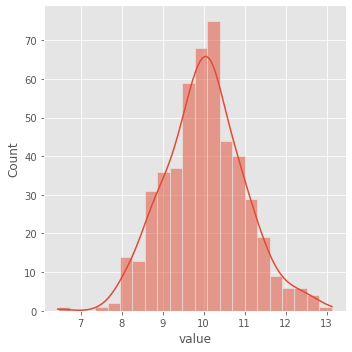

In [68]:
sns.displot(treatment[:-5].value, kde=True);

### Проверим гипотезу с помощью bootstrap

Будем использовать за основу статистики :

1) Среднее

2) Медиану

  0%|          | 0/2000 [00:00<?, ?it/s]

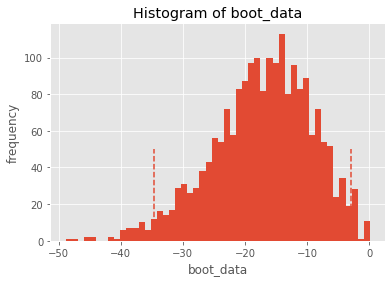

In [56]:
booted_data_mean = get_bootstrap(control.value, treatment.value, boot_it = 2000, statistic = np.mean)

In [57]:
booted_data_mean['p_value']

0.03343894972998323

In [58]:
booted_data_mean["ci"]

,0
0.025,-34.639960
0.975,-2.994954


Если использовать в качестве описательной статистики среднее, то можно отвергнуть нулевую гипотезу.
Потому что p_value < 0.05 и 0 не входит в 95% доверительный интервал 

Но мы помним, что в данных были выбросы.

Посмотрим какие значения мы получим, если будем использовать median

  0%|          | 0/2000 [00:00<?, ?it/s]

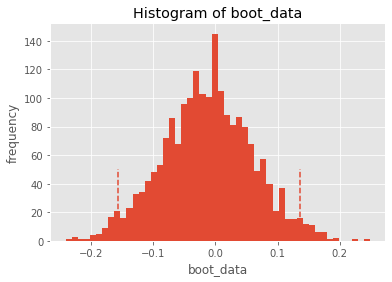

In [59]:
booted_data_median = get_bootstrap(control.value, treatment.value, boot_it = 2000, statistic = np.median)

In [60]:
booted_data_median['p_value']

0.8618705580884436

In [61]:
booted_data_median["ci"]

,0
0.025,-0.156350
0.975,0.136182


Но при использовании np.median нулевую гипотезу мы принимаем.

### Проверим гипотезу с помошью критерия Манна-Уитни

H0: Различия не являются статистически достоверными и носят случайный характер

H1: Различия являются статистически достоверными

In [51]:
stat, p = mannwhitneyu(control.value, treatment.value)
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=124189.500, p=0.859
Same distribution (fail to reject H0)


### Проверим гипотезу с помошью t test'a

С выбросами

In [70]:
ttest_ind(control.value, treatment[:-5].value)

Ttest_indResult(statistic=0.08299135107595523, pvalue=0.9338751428058142)

Без выбросов

In [71]:
ttest_ind(control.value, treatment.value)

Ttest_indResult(statistic=-2.0729020485356604, pvalue=0.038437593613498765)

### Итог

Выбросы играют роль в принятии решения.

Если использовать непараметрический U-критерий Манна-Уитни и в bootstrap медиану, то вывод такой : стат.значимых различий нет.